---
title: Week 5 Tutorial 2, Orchestra Simulation
subtitle: Orchestra Scenario, Carbonate, Water and Calcite simulation
author:
  - name: Timo Heimovaara
    affiliations: Delft University of Technology, department of Geoscience & Engineering
    orcid: 
    email: t.j.heimovaara@tudelft.nl
license: CC-BY-NC-ND-4.0 (https://creativecommons.org/licenses/by-nc-nd/4.0/).
date: 2026-01-07
kernelspec:
    name: python3
    display_name: 'Python 3.13'
---

## Orchestra as a tool
This example illustrates how to use Python and ORCHESTRA to simulate the Carbonate-Water-Calcite system. This system is discussed extensively in Appelo and Postma chapter 5.
The next python cells imports the necessary libararies and checks the path to the input files required for the Orchestra simulation. Please note that this is only required for the jupyter-book version. For a stand-alone version of this notebook you need to start jupyter-lab from the directory with the input files.

In [1]:
# Import libraries required for running all simulations
import os
import sys
from IPython.utils import capture
from IPython.display import display, Markdown
from pathlib import Path
from contextlib import chdir

import numpy as np
import matplotlib.pyplot as plt
import PyORCHESTRA # here, the ORCHESTRA submodule is imported
import pandas as pd
import seaborn as sns

%matplotlib widget
sns.set()

# Prepare a file to capture PyOrchestra output
capture_file = open("pyorchestra_output.log", "w")


# pyOrchestra is implemented in C++
# Save original stdout file descriptor
original_stdout_fd = sys.stdout.fileno()

# Duplicate original stdout so we can restore it later
saved_stdout_fd = os.dup(original_stdout_fd)



# We need to import some Orchestra files. We need to know the path layout on 
# the local machine:
def find_book_root(start: Path | None = None) -> Path:
    """
    Walk upward from `start` (or CWD) until a directory containing Jupyter Book
    marker files is found. Returns the path to the book root.
    Raises FileNotFoundError if no root is found.
    """
    config_any = {"_config.yml", "_config.yaml"}      # some projectrs use .yaml
    myst_any = {"myst.yml", "myst.yaml"}            # jupyter-book uses _toc.yml

    cur = Path(Path.cwd()).resolve()

    for parent in [cur, *cur.parents]:
        children = {f.name for f in parent.iterdir()} if parent.exists() else set()
        has_any_config = bool(config_any & children)
        has_any_myst = bool(myst_any & children)
        if has_any_config and has_any_myst:
            return parent

    raise FileNotFoundError(
        f"Could not find Jupyter Book root (no _config.y* and myst.y* found above {cur})"
    )


def path_from_book_root(*parts: str | Path) -> Path:
    root = find_book_root()
    p = (root.joinpath(*parts)).resolve()
    if not p.exists():
        raise FileNotFoundError(f"Path not found: {p}")
    return p

# In order for orchestra to run we need to change directory to the directory with the input file:


# Example usage:
# input_file = path_from_book_root("content", "week 02", "Orchestra_simulation", "chemistry1.inp")
# print("Input file:", input_file)
   
orchestra_path = path_from_book_root("content", "week 05", "Tutorial-2-Orchestra-Carbonate-system")
# print(orchestra_path)

## Download this script and the required ORCHESTRA files
TODO Create an yml for a local python environment
TODO Create zip file with the correct files. Explain how to install Orchestra using pip in a local python environment.
TODO Update all files so that they are well documented and describe the system

pyorchestra will be initialize with the correct chemistry file...

explain that InVars are the species used to define the totals. 
explain that OutVars is the list of Orchestra variables that are exported to python for post-processing or necessary for simulation.

Once prinicple problem is known we can create and initialize a pyorchestra object.

## Define chemical system: Carbonate, Water and Calcite using the ORCHESTRA-GUI
In order to solve a chemical equilibrium problem with pyOrchestra, we need to define our chemical system first. Orchestra defines this system with a number of text files. The most important one is the so-called chemistry input file (*chemistry1.inp*). This file is most easily made using the Orchestra GUI which can be accessed by clicking on the orchestra2023.jar file.

For the carbonate system we distinguish three types of scenarios: 
1. a scenario with a gas-phase with a fixed closed volume. This implies that the pressure in the gas phase will change based on the chemical processes occuring in the system;
2. a scenario where the gas pressure is assumed to be constant in a closed volume, this implies that the volume of the system changes based on the chemical processes;
3. a scenario where our system is in open contact with the atmosphere, this implies that the partial pressures (and therefore the activities) of the gaseous components do not change as the reactions proceed in our system. This because the volume (and therefore the amount of gaseous species present) is so much larger than our system that we may neglect the changes due to our reactions. For an open reaction in equilibrium with the atmosphere we need another input file. This case is not required for this tutorial.

Similar to the first tutorial of this week we start with a skeleton problem (a working ORCHESTRA simulation and it is convenient to start with the results from tutorial 1) and then adjust the files step by step. 

Using the steps described in Tutorial 1 we created *chemistry_fixedVolume.inp*. The carbonate system we want to analyse is controlled by the following reactions (see also Appelo & Postma, chapter 5):
$$
\begin{aligned}
\text{CO}_2\text{(g)} + \text{H}_2\text{O} &\leftrightharpoons \text{H}_2\text{CO}_3^* \\
\text{H}_2\text{CO}_3^* &\leftrightharpoons \text{H}^+ + \text{HCO}_3^- \\
\text{HCO}_3^- &\leftrightharpoons \text{H}^+ + \text{CO}_3^{-2} \\
\text{H}_2\text{O} &\leftrightharpoons \text{H}^+ + \text{OH}^- \\
\text{CaCO}_3\text{(s)} &\leftrightharpoons \text{Ca}^{+2} + \text{CO}_3^{-2} \\
\end {aligned}
$$

As always when analysing chemical equilibria, all of the reactions are taking place simultaneously, and if we were to add all the reactions together we would obtain the following net reaction:
$$
\begin{aligned}
\text{CO}_2\text{(g)} + \text{H}_2\text{O} + \text{CaCO}_3\text{(s)} &\leftrightharpoons \text{Ca}^{+2} + 2\text{H}\text{CO}_3^- \\
\end {aligned}
$$


```{exercise} Check this calculation
See if you can obtain the above net reaction yourself?
```
From the above net reaction we observe that the Carbonate in the system orginates from $\text{CO}_2\text{g}$ and $\text{CaCO}_3\text{(s)}$, while $\text{Ca}^{+2}$ only originates from $\text{CaCO}_3\text{(s)}$.

As we will be working with a system that contains three phases (gas, water, and solids), we require a back ground gas to maintain gas pressure in the case all of the gaseous species in our reaction were to be consumed. For our case we choose to use Ar[g] at a background pressure of 1 atm. Argon is an inert gas and will not influence our reactions.


```{exercise} Why is it important to have a background gas?
```
Finally we require Orchestra to control the charge balance, we assume that $\text{Na}^+$ and $\text{Cl}^-$ are present in the sytem as well because we assume that we will be able to change the pH in the solution using $\text{HCl}$ or $\text{NaOH}$.

Using all insights from above we generated the following master species table: 

|Primary entity|Phase|Input Variable|Fix log activity|Log activity|Concentration|Phase|Expression|
|--|--|--|--|--|--|--|--|
|Ar[g]|gas||x|0||||
|CO3-2|diss||||1.0e-9|tot||
|Ca+2|diss||||1.0e-9|tot||
|Cl-|diss||x||1.0e-9|tot||
|H+|diss|pH||7.0|||H.logact=-pH|
|H2O|liter||x|-0.0||||
|Na+|diss||x||1.0e-9|tot||

Orchestra will use these primary entities, and their initial values to calculate the total elemental composition in the complete system. The fixed log-activties indicate that the total can vary during the simulation, as long as the log-activity condition is maintained or because Orchestra uses these values to balance the charge of the solution (Na+.tot and Cl-.tot). 

### Phases & Reactions
On the **Phases & Reactions** tab shown in figure [](#phases_reactions) we define the reaction network of our system. Please ensure that all reactions are marked.

### Other tabs
There is no need to change anything on the other tabs as these are correctly set in Tutorial 1.
There is however one thing that you need to check before we can proceed which is the way ORCHESTRA calculates the pressure in the gas phase. This cannot be done with the GUI, but has to done by adding (or unmarking) code in the *chemistry.inp* file itself. This is the reason why we now use *chemistry_fixedVolume.inp* instead of *chemistry1.inp* because we have changed line 68 to
```{code}
@Calc: (5,  "pressure = {CO2[g].con} + {Ar[g].con}")     // is total fluid volume in cell
```
allowing ORCHESTRA to calculate the total pressure as the sum of the partial pressures of the gaseous species defined by us.

For a fixed-pressure problem we need to change this file in a different way as is done in *chemistry_fixedPressure.inp*.

### Using Orchestra to run the scenario
It is possible to use the ORCHESTRA GUI to run the simulation, and this has been prepared using the **Input** and **Output** tabs on the right of the window. Please have look at these tabs and they should be rather "self explanatory". 



## Running the Carbonate-Water-Calcite scenario in a Python notebook
We will use a Python notebook and ORCHESTRA to replicate the graphs shown in Appelo and Postma chapter 5. In addition we will run some test scenarios to illustrate the importance of carbonate and $\text{CO}_2\text{(g)}$ in controlling the pH of water.

We follow the same systematic approach as Tutorial 1, which consists of the following standard steps:
1. define the domain for our problem
2. define the primary species which change during our scenario
3. initialize the problem
4. run the problem
5. process the output

### 1. Define the domain
For our analysis we choose to work with a system containing 1 liter of water and 1 liter of gas phase. The volume of the solid phase is small with respect the total volume and will be neglected for now.

### 2. Define the primary species
The primary species are as defined above with the ORCHESTRA GUI. Please note that the values required by ORCHESTRA have to be in moles. In order to get moles/liter the volume of water has to be set to 1 liter, and the density of water need to be given as well.

### 3. Initialise the problem 
The initial condition for our problem will be defined by setting the amounts of $\text{CO}_2\text{(g)}$ and $\text{CaCO}_3\text{(s)}$ in our system with using CO2[g].tot and CaCO3[s].tot. 

Once pyOrchestra is initialized, running a simulation consists of a series of steps where the values of the required set of input variables are passed via *InVARS* to ORCHESTRA, after which a set of corresponding output variables are passed back in *OutVars*.

ORCHESTRA is initialized in pyOrchestra using the inputfile *chemistry1.inp*, created above with the ORCHESTRA-GUI. After initialization in Python, we know which variables will be passed through *OutVars* and can be used in *InVars*.

The following code shows how to do this.
```{note} 
It is relatively easy to change the OutVars array. In order to find all possible variables in ORCHESTRA, check the **Phases & Reactions** tab on the **Chemistry** tab in the ORCHESTRA-GUI .
```


In [2]:
#--- Initialize problem --- 
# for initialization we need to temporarily move to the directory containing the 'chemistry1.inp' file.
with chdir(orchestra_path):

    # Input file is generated with Orchestra GUI
    InputFile = 'chemistry_fixedVolume.inp'
    NoCells = 1 #only 1 cell to have a 0-D system with 1liter of water
    
    # We define the input variables that will be changed in the script
    InVars = np.array(['pH',
                       'Ca+2.tot', 
                       'CO2[g].tot',
                       'watervolume',
                       'gasvolume'
                       ])
    
    # We select the output from Orchestra we need to use
    OutVars = np.array(['pH', 'H+.con', 'H+.tot', 'H+.logact',
                        'OH-.tot', 'OH-.con', 'OH-.logact',
                        'CO2[g].tot', 'CO2[g].con', 'CO2[g].diss', 'CO2[g].logact',
                        'CO3-2.tot', 'CO3-2.con', 'CO3-2.logact','CO3-2.diss',
                        'HCO3-.tot', 'HCO3-.con', 'HCO3-.logact', 'HCO3-.diss',
                        'H2CO3.tot', 'H2CO3.con', 'H2CO3.logact', 'H2CO3.diss',
                        'Ca+2.tot', 'Ca+2.con', 'Ca+2.logact', 'Ca+2.diss', 
                        'Cl-.tot', 'Cl-.con', 'Cl-.logact', 'Cl-.diss', 
                        'Na+.tot', 'Na+.con', 'Na+.logact', 'Na+.diss',
                        'CaCO3.con', 'CaHCO3+.con', 'CaOH+.con', 
                        'Calicite[s].si', 'Calcite[s].tot', 'Calcite[s].con', 'Calcite[s].logact',
                        'Aragonite[s].si', 'Portlandite[s].si', 'Lime[s].si',
                        'I', 'chargebalance', 'watervolume', 'gasvolume','pressure' ])

    # Associate a variable with the pyOrchestra.ORCHESTRA() class
    p = PyORCHESTRA.ORCHESTRA()

    # Initialize the class with the parameters defined above
    p.initialise(InputFile, NoCells, InVars, OutVars)


Reading and expanding calculator new stylechemistry_fixedVolume.inp
Scanning file: chemistry_fixedVolume.inp
Including file: objects2025.txt
Scanning file: chemistry_fixedVolume.inp
Including file: objects2025.txt
Including file: chemistry_fixedVolume.inp
Including file: objects2025.txt
0.025 sec.
	Reading variables .... 0.01 s
testing:
12:pH
10:Ca+2.tot
17:CO2[g].tot
18:watervolume
19:gasvolume
12:pH
20:H+.con
21:H+.tot
22:H+.logact
23:OH-.tot
24:OH-.con
25:OH-.logact
17:CO2[g].tot
26:CO2[g].con
27:CO2[g].diss
28:CO2[g].logact
8:CO3-2.tot
29:CO3-2.con
7:CO3-2.logact
30:CO3-2.diss
31:HCO3-.tot
32:HCO3-.con
33:HCO3-.logact
34:HCO3-.diss
35:H2CO3.tot
36:H2CO3.con
37:H2CO3.logact
38:H2CO3.diss
10:Ca+2.tot
39:Ca+2.con
9:Ca+2.logact
40:Ca+2.diss
41:Cl-.tot
42:Cl-.con
11:Cl-.logact
43:Cl-.diss
44:Na+.tot
45:Na+.con
13:Na+.logact
46:Na+.diss
47:CaCO3.con
48:CaHCO3+.con
49:CaOH+.con
50:Calicite[s].si
51:Calcite[s].tot
52:Calcite[s].con
53:Calcite[s].logact
54:Aragonite[s].si
55:Portlandite[s].

Please note that the output of this code is what ORCHESTRA echos back. ORCHESTRA uses a set of variables in order to store the input variables and the results of the calculations, in this case 33. The top part of the output shows the output requested by us through *OutVars* together with the values used during initialization.

### Run the Problem
The aim of the scenario for now is to see if we can replicate a similar graph as figure 4.1 of Appelo and Postma.

:::{figure} images/Appelo&Postma_fig5.5.png
:name: appelo_fig5_5
:align: center
:width: 75%
Appelo & Postma figure 5.5
:::

In our simulation we control the total amount of carbonate in the system with CO2[g].tot, if we require carbonate in a mineral phase we can add this by defining the total amount of Ca+2.tot in the system, the system will allow Calcite (and other Calcium carbonate minerals to precipitate). As the pH in the figure ranges from 3 to 13 we choose to have pH as the "driving" variable for our scenario.
Finally the total amount of Carbonate in the system is not really relevant as the graph shows a percentage of $\text{HCO}_3^-$, we choose to set CO2[g].tot to 1 mmol in this system.

### Step 1: Define the default InVars

In [3]:
# %%
# Step 1, initial condition.
# InVars need to contain floats
IN = np.array([np.ones_like(InVars)]).astype(float)

# Define initial conditions
CO2_ini = 1e-3 # moles
Ca_ini = 1e-20 # moles

IN[0][np.where(InVars == 'pH')] = 12 # moles
IN[0][np.where(InVars == 'CO3-2.tot')] = CO2_ini # moles
IN[0][np.where(InVars == 'Ca+2.tot')] = Ca_ini # No Gypsum (initial conditions)
IN[0][np.where(InVars == 'watervolume')] = 1.0 # 1 liter
IN[0][np.where(InVars == 'gasvolume')] = 1.0 # 1 liter

# Calculate equilibrium conditions for initial situation 
OUT = p.set_and_calculate(IN)
Res_initial = pd.DataFrame(OUT,columns=OutVars)
print(Res_initial.T)

Try a first calculation with iia switched off....
Parsing expressions of chemistry_fixedVolume.inp..... 
Optimizing expressions of chemistry_fixedVolume.inp..... 0.108 sec.
1802 variables, 4701 expressions, 5 equations.
First calculation was successful!
Repeat calculation with iia switched on..
Switching on: logI: -2
This was successful!!
                              0
pH                 1.200000e+01
H+.con             1.196786e-12
H+.tot            -1.206275e-02
H+.logact         -1.200000e+01
OH-.tot            1.215944e-02
OH-.con            1.215944e-02
OH-.logact        -1.997025e+00
CO2[g].tot         5.291122e-09
CO2[g].con         5.291122e-09
CO2[g].diss        0.000000e+00
CO2[g].logact     -8.276452e+00
CO3-2.tot          1.000000e-02
CO3-2.con          7.737416e-03
CO3-2.logact      -2.423470e+00
CO3-2.diss         9.999995e-03
HCO3-.tot          9.550585e-05
HCO3-.con          9.550585e-05
HCO3-.logact      -4.094441e+00
HCO3-.diss         9.550585e-05
H2CO3.tot          

### Step 2: Iterate over pH values
We run the problem from pH 2 to pH 13

In [4]:
# Define the incremental pH change

pH_range = np.linspace(0, 13, 13*5+1)

#  Prepare an array to store all results from our scenario
all_Res = np.zeros([len(pH_range),len(OutVars)])

# loop over pH_Range 
# we use a counter ii in order to store the results
ii = -1
for pH in pH_range:
    # change Gypsum in InVars
    IN[0][np.where(InVars == 'pH')] = pH

    # run ORCHESTRA
    OUT = p.set_and_calculate(IN)
    ii = ii + 1
    all_Res[ii] = OUT[0]

    # Create a dataframe from all_Res
Res_Simulation = pd.DataFrame(all_Res,columns=OutVars)

## Process Output
To process the output we first generate a similar figure as from Appelo and Postma. 
We need to calculate the percentage of $\text{HCO}_3^-$, which is quite easy as this is the ratio of HCO3-.diss/CO3-2.diss

(3.0, 13.0)

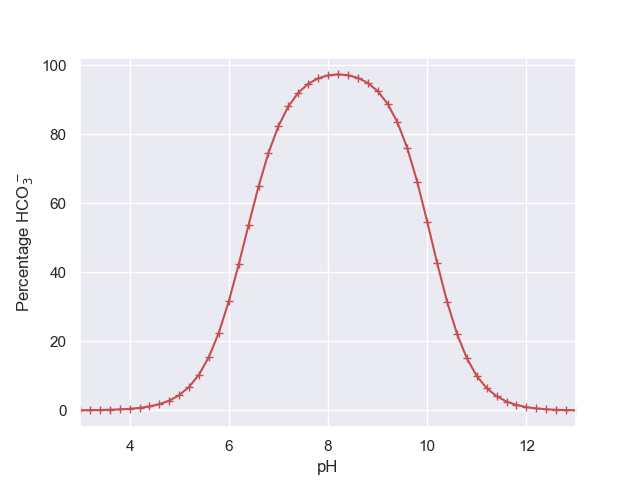

In [5]:
# Process output
# we can easily make the plot 
fig1,ax1 = plt.subplots()
ax1.plot(Res_Simulation['pH'],Res_Simulation['HCO3-.diss']/Res_Simulation['CO3-2.diss']*100, 'r+-' )
ax1.grid(True)
ax1.set_xlabel('pH')
ax1.set_ylabel(r'Percentage HCO$_3^-$')
ax1.set_xlim(3,13)

If we compare our figure with figure 5.5 from Appelo and Postma we see that it is nearly identical. 

### Plot the Actvitiy diagram for a closed system
We now would like to create a plot similar to figure 5.7 from Appelo and Postma:
:::{figure} images/Appelo&Postma_fig5.7.png
:name: appelo_fig5_7
:align: center
:width: 75%
Appelo & Postma figure 5.7
:::

(0.0, 14.0)

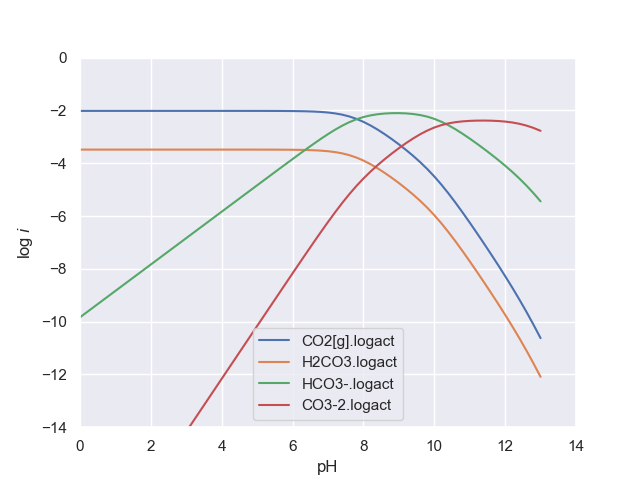

In [6]:
fig2,ax2 = plt.subplots()
species_list = ['CO2[g].logact','H2CO3.logact', 'HCO3-.logact','CO3-2.logact']
for species in species_list:
    ax2.plot(Res_Simulation['pH'], Res_Simulation[species], '-')
ax2.grid(True)
ax2.legend(species_list)
ax2.set_xlabel('pH')
ax2.set_ylabel(r'log $i$')
ax2.set_ylim(-14,0)
ax2.set_xlim(0,14)

The results are slightly different from the results presented in Appelo and Postma because the highest levels for  $\mathrm{H}_2\mathrm{CO}_3$,  $\text{HCO}_3^-$ and  $\text{CO}_3^{-2}$ are not equal to each other.
```{exercise} Explain
I believe that the drawing in Appelo and Postma is wrong or perhaps is based on a different assumption. In our model we look at the total amount of $\text{CO}_2$ present in the system, both the gas as well as the liquid phase. When pH rises, all the $\text{CO}_2$ is stripped from the gas phase and stored in the solution. The total amount of CO2[g].tot was defined in our input as 1e-3 moles per liter which corresponds well with the above graph. Please note that the log scale on the y axis makes the plot suggestive. The H2CO3 concentration is about 1.5 order of magnitude smaller that the CO2[g].tot value. This makes the H2CO3 concentration, negligible compared to the total amount of CO2[g].tot in the system. At low pH values, most of the CO2 is in the gas phase! You can make a plot with the CO2[g].tot value and then zoom in to the graph to see that the values indeed are different!

1. Explain where this difference comes from.
2. Retry the simulation by modifying the simulation in order to obtain exactly the same figure as figure 5.7 from Appelo and Postma?

```


(0.0, 14.0)

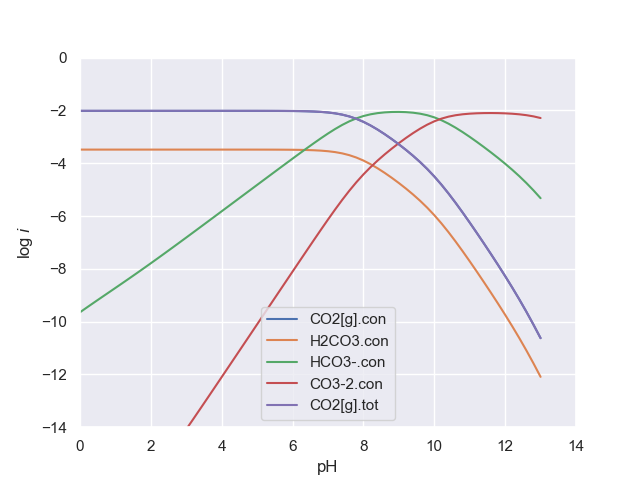

In [7]:
fig3,ax3 = plt.subplots()
species_list = ['CO2[g].con','H2CO3.con', 'HCO3-.con','CO3-2.con', 'CO2[g].tot']
for species in species_list:
    ax3.plot(Res_Simulation['pH'], np.log10(Res_Simulation[species]), '-')
ax3.grid(True)
ax3.legend(species_list)
ax3.set_xlabel('pH')
ax3.set_ylabel(r'log $i$')
ax3.set_ylim(-14,0)
ax3.set_xlim(0,14)

## How will the presence of Calcite change the system?
When a mineral such as Calcite is present, it will buffer changes in the solution. As the pH changes, Calcite will precipitate or dissolve. We can evaluate this buffering process, by monitoring changes in the concentration of $\text{Ca}^{+2}$ as a function of pH.

In [8]:
# Define the incremental pH change

# We add Calcite to the system by increasing the Ca+2 concentration and adding an equivalent amount of CO3-2
# to keep charge balance. 
IN[0][np.where(InVars == 'Ca+2.tot')] = Ca_ini+1 #
IN[0][np.where(InVars == 'CO3-2.tot')] = CO2_ini+1 # to keep charge balance

pH_range = np.linspace(0, 13, 13*5+1)

#  Prepare an array to store all results from our scenario
all_Res = np.zeros([len(pH_range),len(OutVars)])

# loop over pH_Range 
# we use a counter ii in order to store the results
ii = -1
for pH in pH_range:
    # change Gypsum in InVars
    IN[0][np.where(InVars == 'pH')] = pH

    # run ORCHESTRA
    OUT = p.set_and_calculate(IN)
    ii = ii + 1
    all_Res[ii] = OUT[0]

    # Create a dataframe from all_Res
Res_Simulation_Calcite = pd.DataFrame(all_Res,columns=OutVars)

chemistry_fixedVolume.inp: Improving start estimations:.
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&|
Trying better start estimations was successful!!


(0.0, 14.0)

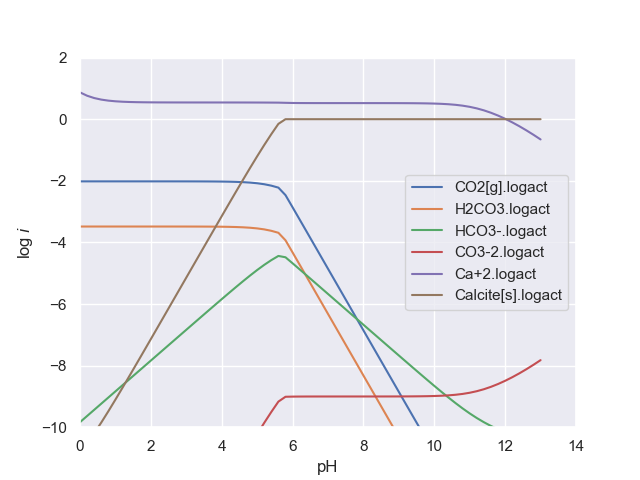

In [9]:
fig4,ax4 = plt.subplots()
species_list = ['CO2[g].logact','H2CO3.logact', 'HCO3-.logact','CO3-2.logact','Ca+2.logact', 'Calcite[s].logact']
for species in species_list:
    ax4.plot(Res_Simulation_Calcite['pH'], Res_Simulation_Calcite[species], '-')
ax4.grid(True)
ax4.legend(species_list)
ax4.set_xlabel('pH')
ax4.set_ylabel(r'log $i$')
ax4.set_ylim(-10,2)
ax4.set_xlim(0,14)

Clearly the presence of Calcite profoundly changes the system. Presence of calcite will limit the maximum concentration dissolved $\text{HCO}_3^-$ and $\text{CO}_3^{-2}$. At low pH-values, all the calcite will be dissolved, however most of the carbonate will move to the gas phase increasing the gas pressure in the fixed gas volume. At low pH most of the carbonate is present in the gas phase, at intermediate and high pH most of the carbonate is present in Calcite. When Calcite is present, most of the $\text{Ca}^{+2}$ is present in the Calcite as well, but a low pH is will be dissolved in the solution.

It is interesting to see how ions for the charge balance are behaving as well:

(0.0, 14.0)

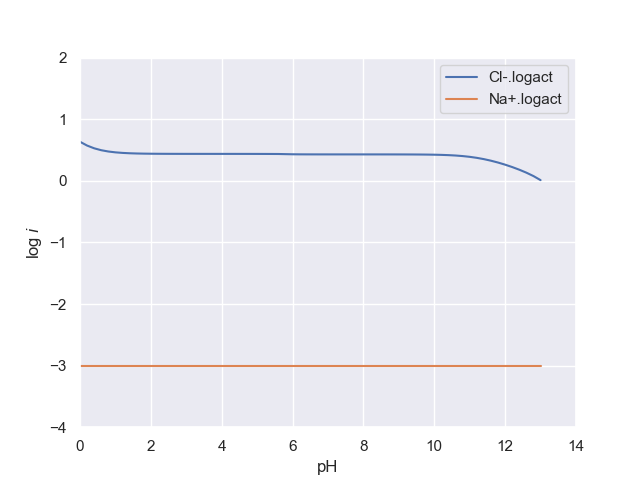

In [10]:
fig5,ax5 = plt.subplots()
species_list = ['Cl-.logact','Na+.logact']
for species in species_list:
    ax5.plot(Res_Simulation_Calcite['pH'], Res_Simulation_Calcite[species], '-')
ax5.grid(True)
ax5.legend(species_list)
ax5.set_xlabel('pH')
ax5.set_ylabel(r'log $i$')
ax5.set_ylim(-4,2)
ax5.set_xlim(0,14)

``` {exercise}
Explain the concentration behavior of $\text{Cl}^-$ and $\text{Na}^+$. Please note that the experiment was run by changing the pH, while keeping the total of the calcium and carbonate species constant.
```